In [1]:
import pandas as pd

df = pd.read_csv("Fish.csv")
df.head()


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


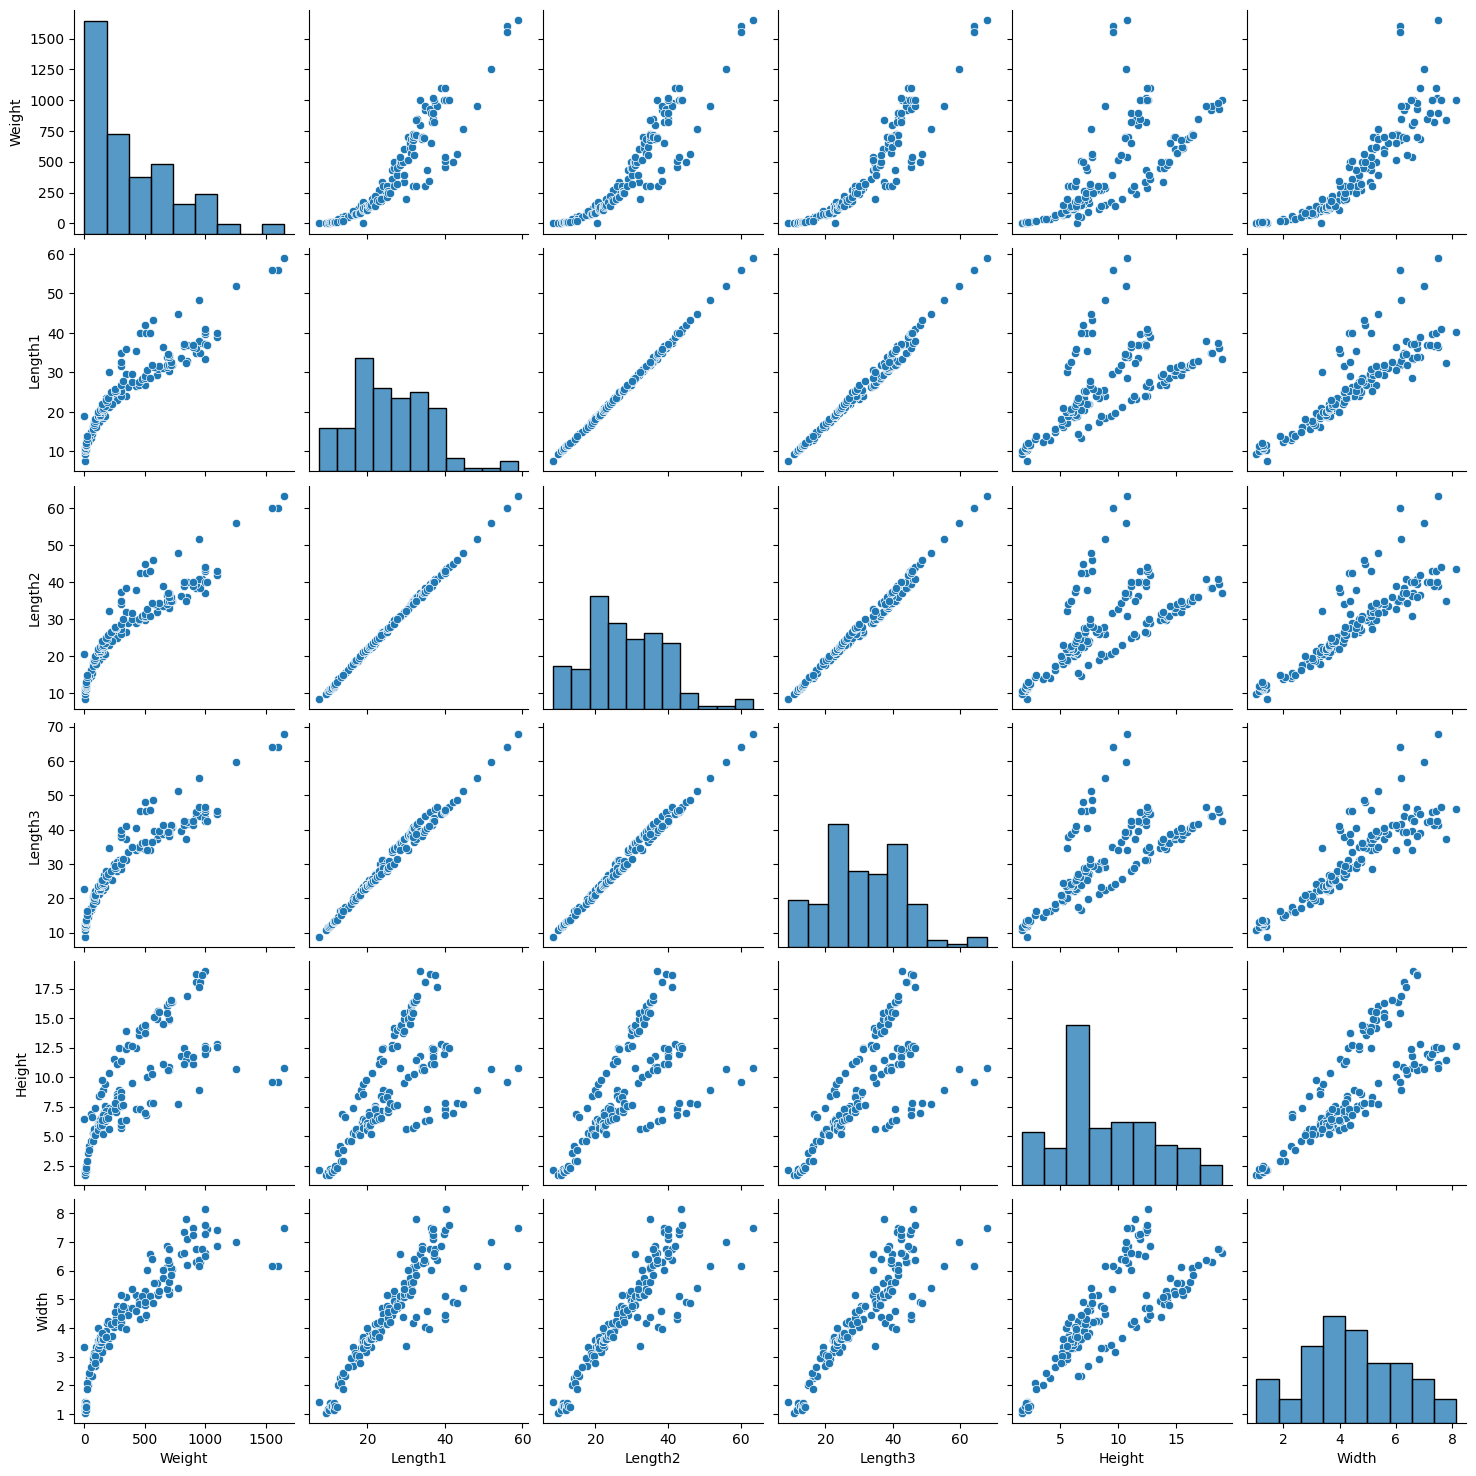

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.show()


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Weight"])
y = df["Weight"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((127, 6), (32, 6))

In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

rmse_baseline


np.float64(381.4741042849773)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

# colonnes
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features),
    ]
)

# pipeline complet
model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("ridge", Ridge(alpha=1.0))
    ]
)

model


,steps,"[('preprocessing', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_model = mean_squared_error(y_test, y_pred)
rmse_model = np.sqrt(mse_model)

rmse_baseline, rmse_model

(np.float64(381.4741042849773), np.float64(88.23700054959724))

In [7]:
results = pd.DataFrame({
    "Model": ["Baseline (mean)", "Ridge (alpha=1.0)"],
    "RMSE": [rmse_baseline, rmse_model]
})

results

,Model,RMSE
0,Baseline (mean),381.474104
1,Ridge (alpha=1.0),88.237001


In [8]:
from sklearn.linear_model import Ridge

alphas = [0.1, 1.0, 10.0]
rmses = []

for alpha in alphas:
    model = Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("ridge", Ridge(alpha=alpha))
        ]
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

tuning_results = pd.DataFrame({
    "alpha": alphas,
    "RMSE": rmses
})

tuning_results

,alpha,RMSE
0,0.1,86.780416
1,1.0,88.237001
2,10.0,109.931326
